# Setup

In [1]:
import os
import gc
import time
import warnings
gc.enable()
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.metrics import mean_squared_log_error, roc_auc_score

In [3]:
DATA_DIR = '/kaggle/input/mh-decode-aqi'
train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')
sample_sub = pd.read_csv(f'{DATA_DIR}/submission.csv')

# Data overview

In [4]:
train.shape, test.shape, sample_sub.shape

((495512, 15), (212363, 14), (212363, 1))

In [5]:
train.isna().sum().sum(), test.isna().sum().sum()

(152041, 65129)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495512 entries, 0 to 495511
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        495512 non-null  object 
 1   Datetime    495512 non-null  object 
 2   PM2.5       488851 non-null  float64
 3   PM10        484693 non-null  float64
 4   NO          469994 non-null  float64
 5   NO2         489898 non-null  float64
 6   NOx         485090 non-null  float64
 7   NH3         474977 non-null  float64
 8   CO          490495 non-null  float64
 9   SO2         483354 non-null  float64
 10  O3          471898 non-null  float64
 11  Benzene     486993 non-null  float64
 12  Toluene     484508 non-null  float64
 13  Xylene      483352 non-null  float64
 14  AQI_Bucket  495512 non-null  int64  
dtypes: float64(12), int64(1), object(2)
memory usage: 56.7+ MB


In [7]:
train.sample()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket
298863,Mumbai,2015-03-11 05:00:00,67.6,119.1,17.4,28.9,188.0,23.6,0.0,14.0,34.8,0.0,0.0,0.0,0


In [8]:
test.sample()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
83851,Hyderabad,2019-02-03 12:00:00,56.0,NaN,1.7,32.8,18.8,18.1,0.5,3.7,48.4,1.4,6.0,0.5


In [9]:
TARGET = 'AQI_Bucket'
features = list(test.columns)

# Target distribution

In [10]:
train[TARGET].nunique()

7

In [11]:
train[TARGET].unique()

array([5, 1, 3, 4, 6, 0, 2])

In [12]:
train[TARGET].value_counts(normalize=True)

5    0.1435
4    0.1433
3    0.1433
0    0.1432
6    0.1425
2    0.1422
1    0.1419
Name: AQI_Bucket, dtype: float64

Perfectly balanced.

# Feature exploration

### City

In [13]:
train['City'].nunique(), test['City'].nunique()

(26, 26)

In [14]:
train_cities = set(train['City'].unique())
test_cities = set(test['City'].unique())
len(train_cities.intersection(test_cities))

26

In [15]:
train['City'].unique()

array(['Jaipur', 'Amritsar', 'Amaravati', 'Kochi', 'Ahmedabad', 'Lucknow',
       'Thiruvananthapuram', 'Talcher', 'Guwahati', 'Delhi', 'Chandigarh',
       'Visakhapatnam', 'Gurugram', 'Mumbai', 'Bengaluru', 'Coimbatore',
       'Brajrajnagar', 'Hyderabad', 'Chennai', 'Patna', 'Kolkata',
       'Bhopal', 'Jorapokhar', 'Aizawl', 'Shillong', 'Ernakulam'],
      dtype=object)

In [16]:
pd.DataFrame(
    data={
        'train': train['City'].value_counts(normalize=True).sort_index(),
        'test': test['City'].value_counts(normalize=True).sort_index()
    },
    index=sorted(train_cities)
).T

,Ahmedabad,Aizawl,Amaravati,Amritsar,Bengaluru,Bhopal,Brajrajnagar,Chandigarh,Chennai,Coimbatore,Delhi,Ernakulam,Gurugram,Guwahati,Hyderabad,Jaipur,Jorapokhar,Kochi,Kolkata,Lucknow,Mumbai,Patna,Shillong,Talcher,Thiruvananthapuram,Visakhapatnam
train,0.0679,0.0037,0.0321,0.0414,0.0680,0.0099,0.0316,0.0102,0.0683,0.0131,0.0681,0.0055,0.0569,0.0168,0.0679,0.0375,0.0397,0.0054,0.0277,0.0680,0.0682,0.0631,0.0104,0.0312,0.0376,0.0496
test,0.0684,0.0039,0.0325,0.0413,0.0683,0.0094,0.0321,0.0104,0.0675,0.0129,0.0681,0.0052,0.0569,0.0172,0.0680,0.0382,0.0393,0.0054,0.0272,0.0682,0.0678,0.0626,0.0105,0.0315,0.0377,0.0493


In [17]:
train.groupby('City')[TARGET].describe().T

City,Ahmedabad,Aizawl,Amaravati,Amritsar,Bengaluru,Bhopal,Brajrajnagar,Chandigarh,Chennai,Coimbatore,Delhi,Ernakulam,Gurugram,Guwahati,Hyderabad,Jaipur,Jorapokhar,Kochi,Kolkata,Lucknow,Mumbai,Patna,Shillong,Talcher,Thiruvananthapuram,Visakhapatnam
count,33663.0000,1857.0000,15888.0000,20504.0000,33678.0000,4912.0000,15646.0000,5052.0000,33854.0000,6479.0000,33731.0000,2746.0000,28179.0000,8348.0000,33661.0000,18601.0000,19683.0000,2700.0000,13732.0000,33700.0000,33792.0000,31255.0000,5165.0000,15462.0000,18651.0000,24573.0000
mean,3.0069,3.0447,3.0072,3.0068,2.9874,3.0102,3.0043,3.0087,2.9949,3.0244,3.0052,2.9774,3.0080,2.9980,2.9943,3.0062,3.0082,2.9522,2.9822,3.0190,2.9936,2.9933,3.0159,3.0380,2.9984,2.9949
std,1.9995,2.0312,2.0031,2.0022,1.9988,1.9824,2.0068,1.9970,2.0034,2.0112,2.0073,1.9946,1.9963,1.9969,2.0016,1.9940,2.0005,1.9906,2.0011,1.9964,1.9986,1.9952,1.9732,1.9994,1.9989,2.0005
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
50%,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000
75%,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000
max,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000


In [18]:
pd.crosstab(index=train['City'], columns=train[TARGET]).T

City,Ahmedabad,Aizawl,Amaravati,Amritsar,Bengaluru,Bhopal,Brajrajnagar,Chandigarh,Chennai,Coimbatore,Delhi,Ernakulam,Gurugram,Guwahati,Hyderabad,Jaipur,Jorapokhar,Kochi,Kolkata,Lucknow,Mumbai,Patna,Shillong,Talcher,Thiruvananthapuram,Visakhapatnam
AQI_Bucket,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4739,280,2304,2920,4790,679,2244,698,4939,926,4892,400,4014,1208,4853,2630,2823,415,2007,4751,4852,4513,703,2173,2664,3558
1,4926,242,2212,2895,4955,683,2240,744,4773,936,4776,391,3945,1144,4866,2657,2759,357,1944,4731,4806,4385,704,2111,2653,3489
2,4712,256,2212,2988,4780,726,2215,722,4779,885,4726,405,3990,1224,4715,2599,2809,394,1992,4819,4862,4462,784,2206,2705,3480
3,4749,261,2356,2895,4860,726,2239,712,4858,870,4802,367,4160,1221,4750,2716,2786,411,1957,4752,4866,4551,766,2232,2623,3531
4,4835,255,2233,2900,4706,712,2204,740,4864,975,4799,413,4041,1161,4895,2730,2885,381,1935,4916,4797,4531,757,2197,2697,3465
5,4928,281,2284,2941,4830,691,2221,700,4816,943,4876,398,3981,1212,4827,2619,2791,383,1970,4934,4810,4409,727,2292,2651,3608
6,4774,282,2287,2965,4757,695,2283,736,4825,944,4860,372,4048,1178,4755,2650,2830,359,1927,4797,4799,4404,724,2251,2658,3442


### Datetime

In [19]:
train['Datetime'] = pd.to_datetime(train['Datetime'])
test['Datetime'] = pd.to_datetime(test['Datetime'])

In [20]:
train['Datetime'].describe()

count                  495512
unique                  48191
top       2020-04-03 09:00:00
freq                       25
first     2015-01-01 01:00:00
last      2020-07-01 00:00:00
Name: Datetime, dtype: object

In [21]:
test['Datetime'].describe()

count                  212363
unique                  47165
top       2020-05-28 23:00:00
freq                       17
first     2015-01-01 01:00:00
last      2020-07-01 00:00:00
Name: Datetime, dtype: object

In [22]:
train.groupby('City')['Datetime'].describe().T

City,Ahmedabad,Aizawl,Amaravati,Amritsar,Bengaluru,Bhopal,Brajrajnagar,Chandigarh,Chennai,Coimbatore,Delhi,Ernakulam,Gurugram,Guwahati,Hyderabad,Jaipur,Jorapokhar,Kochi,Kolkata,Lucknow,Mumbai,Patna,Shillong,Talcher,Thiruvananthapuram,Visakhapatnam
count,33663,1857,15888,20504,33678,4912,15646,5052,33854,6479,33731,2746,28179,8348,33661,18601,19683,2700,13732,33700,33792,31255,5165,15462,18651,24573
unique,33663,1857,15888,20504,33678,4912,15646,5052,33854,6479,33731,2746,28179,8348,33661,18601,19683,2700,13732,33700,33792,31255,5165,15462,18651,24573
top,2019-05-16 03:00:00,2020-05-17 10:00:00,2018-11-12 10:00:00,2017-04-27 19:00:00,2018-07-28 14:00:00,2019-11-26 01:00:00,2019-04-20 01:00:00,2020-04-19 06:00:00,2017-07-17 10:00:00,2020-06-22 16:00:00,2017-01-04 06:00:00,2020-03-02 21:00:00,2018-10-09 13:00:00,2020-02-08 19:00:00,2020-03-11 10:00:00,2019-05-04 01:00:00,2018-08-26 06:00:00,2020-06-19 09:00:00,2020-05-28 07:00:00,2020-06-04 05:00:00,2019-09-26 16:00:00,2017-07-13 13:00:00,2020-06-02 01:00:00,2019-06-08 08:00:00,2019-05-02 09:00:00,2016-08-23 07:00:00
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
first,2015-01-01 02:00:00,2020-03-11 09:00:00,2017-11-24 17:00:00,2017-02-27 13:00:00,2015-01-01 08:00:00,2019-09-17 11:00:00,2017-12-07 21:00:00,2019-09-02 11:00:00,2015-01-01 01:00:00,2019-06-12 12:00:00,2015-01-01 01:00:00,2020-01-22 13:00:00,2015-11-27 15:00:00,2019-02-16 23:00:00,2015-01-04 14:00:00,2017-06-14 08:00:00,2017-04-20 08:00:00,2020-01-22 11:00:00,2018-04-10 10:00:00,2015-01-01 01:00:00,2015-01-01 01:00:00,2015-06-01 15:00:00,2019-08-27 17:00:00,2017-12-20 16:00:00,2017-06-16 15:00:00,2016-07-01 12:00:00
last,2020-06-30 23:00:00,2020-06-30 23:00:00,2020-06-30 23:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-06-30 23:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-06-30 23:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-06-30 22:00:00,2020-06-30 23:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00


In [23]:
train.groupby(TARGET)['Datetime'].describe().T

AQI_Bucket,0,1,2,3,4,5,6
count,70975,70324,70447,71017,71024,71123,70602
unique,36068,36048,35981,35996,36136,36086,35968
top,2019-09-06 19:00:00,2020-05-16 01:00:00,2020-03-30 12:00:00,2020-06-06 01:00:00,2020-04-06 06:00:00,2019-11-26 16:00:00,2020-01-09 10:00:00
freq,9,9,10,9,10,10,10
first,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 01:00:00,2015-01-01 04:00:00,2015-01-01 02:00:00,2015-01-01 01:00:00,2015-01-01 03:00:00
last,2020-07-01 00:00:00,2020-06-30 23:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00


In [24]:
train['year'] = train['Datetime'].dt.year - 2015 # 2015 is the earliest year
test['year'] = test['Datetime'].dt.year - 2015

train['month'] = train['Datetime'].dt.month
test['month'] = test['Datetime'].dt.month

train['day'] = train['Datetime'].dt.day
test['day'] = test['Datetime'].dt.day

train['day_of_week'] = train['Datetime'].dt.day_of_week
test['day_of_week'] = test['Datetime'].dt.day_of_week

train['hour'] = train['Datetime'].dt.hour
test['hour'] = test['Datetime'].dt.hour

In [25]:
datetime_features = ['Datetime', 'year', 'month', 'day', 'day_of_week', 'hour']
train[datetime_features].sample()

,Datetime,year,month,day,day_of_week,hour
346820,2016-08-28 04:00:00,1,8,28,6,4


In [26]:
train = train.drop('Datetime', axis=1)
test = test.drop('Datetime', axis=1)
datetime_features.remove('Datetime')

### PM*

In [27]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    ax[0].grid(True, which='major')
    ax[0].minorticks_on()
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    ax[1].grid(True, which='major')
    ax[1].minorticks_on()
    fig.tight_layout()
    plt.show()

In [28]:
def explore_cont(feature):
    #Missing values
    train_missing_pct = train[feature].isna().sum() / len(train) * 100
    test_missing_pct = test[feature].isna().sum() / len(test) * 100
    print(f'Missing values %: Train - {train_missing_pct:.2f}, Test - {test_missing_pct:.2f}')
    #Feature distribution 
    describe_df = pd.DataFrame()
    describe_df.index = train[feature].describe().index
    describe_df['Train'] = train[feature].describe().values
    describe_df['Test'] = test[feature].describe().values
    print('\nFeature distribution:')
    display(describe_df.T)
    plot_cont(feature)
    print('\nFeature distribution grouped by target:')
    display(train.groupby(TARGET)[feature].describe())
    print(f'\nTarget distribution for missing values:')
    if train_missing_pct > 0:
        display(train.loc[train[feature].isna()][TARGET].describe().to_frame().T) 

Missing values %: Train - 1.34, Test - 1.40

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,488851.0,67.5943,66.5186,0.0,31.0,60.4,68.2,1000.0
Test,209397.0,67.6541,66.9509,0.0,31.0,60.3,68.1,1000.0


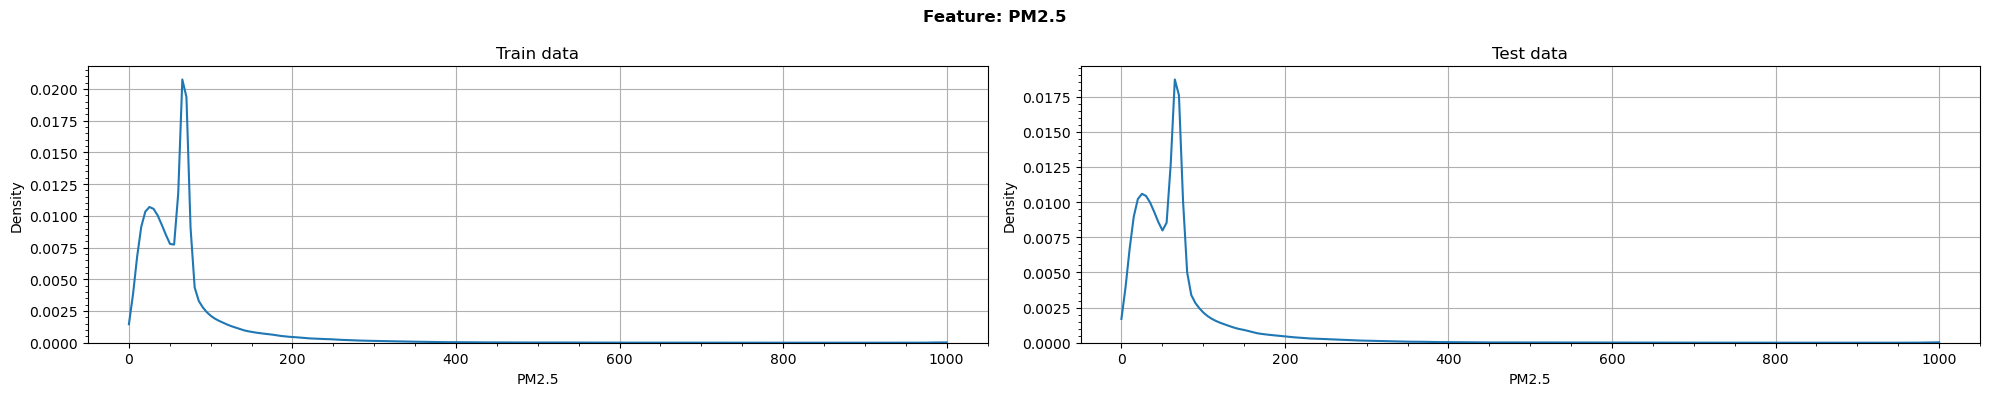


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,69981.0,67.5652,66.7785,0.0,30.8,60.4,68.1,1000.0
1,69327.0,67.3185,65.3062,0.0,30.9,60.2,68.2,1000.0
2,69510.0,67.5362,67.7162,0.0,31.0,60.3,67.8,1000.0
3,70096.0,67.2697,66.4875,0.0,30.9,59.9,68.0,1000.0
4,70085.0,67.9630,67.1948,0.0,30.9,60.6,68.7,1000.0
5,70205.0,67.8861,66.5342,0.0,31.2,60.5,68.4,1000.0
6,69647.0,67.6177,65.5717,0.0,31.0,60.9,68.5,1000.0



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,6661.0,2.959,2.0159,0.0,1.0,3.0,5.0,6.0


In [29]:
explore_cont('PM2.5')

Missing values %: Train - 2.18, Test - 2.24

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,484693.0,119.1336,79.6468,0.0,79.6,119.1,119.1,1000.0
Test,207609.0,118.9684,78.9494,0.0,79.5,119.1,119.1,1000.0


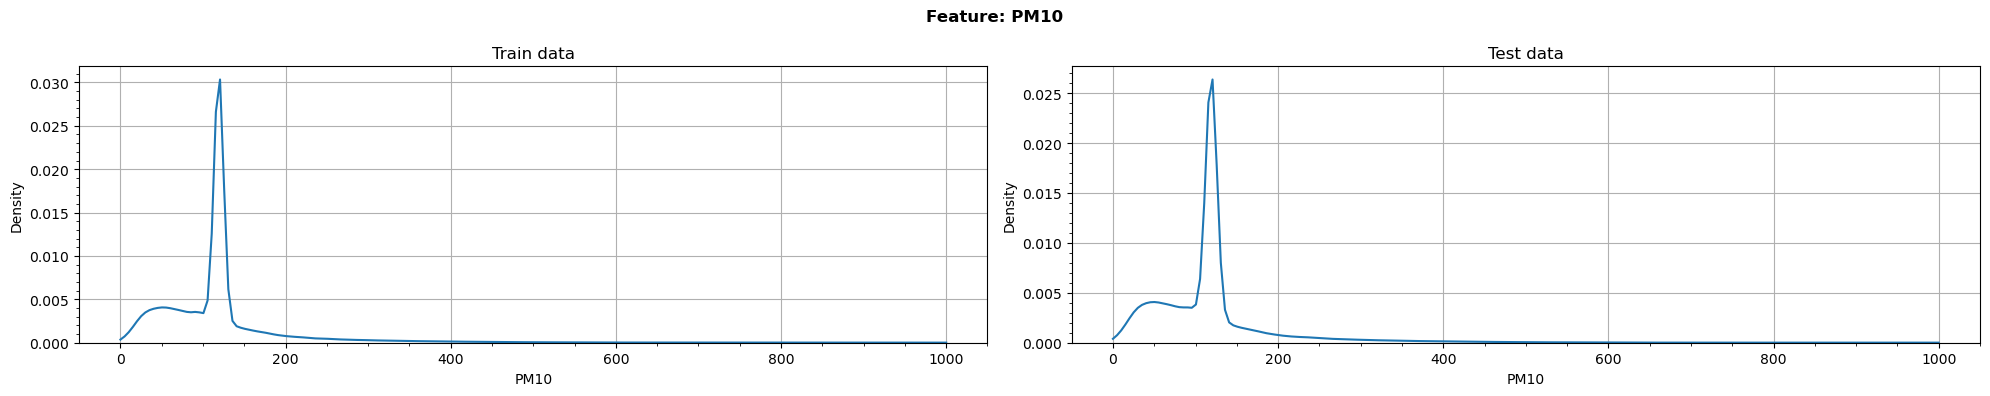


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,69429.0,119.3611,81.5047,0.0,79.3,119.1,119.1,1000.0
1,68808.0,118.9241,78.4810,0.0,79.8,119.1,119.1,1000.0
2,68939.0,118.7095,78.2380,0.0,79.4,119.1,119.1,1000.0
3,69464.0,118.8550,78.9522,0.0,79.2,119.1,119.1,1000.0
4,69438.0,119.4983,80.9295,0.0,79.8,119.1,119.1,1000.0
5,69619.0,118.9592,79.1966,0.0,79.7,119.1,119.1,1000.0
6,68996.0,119.6269,80.1497,0.0,80.1,119.1,119.1,1000.0



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,10819.0,3.0216,2.0061,0.0,1.0,3.0,5.0,6.0


In [30]:
explore_cont('PM10')

Both PM2.5 and PM10 missing:

In [31]:
len(train.loc[(train['PM2.5'].isna()) & (train['PM10'].isna())])

135

In [32]:
len(test.loc[(test['PM2.5'].isna()) & (test['PM10'].isna())])

56

High PM* values:

In [33]:
train.loc[(train['PM2.5'] > 300) & (train['PM10'] > 300)].sample(5)

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,year,month,day,day_of_week,hour
396602,Delhi,448.6,624.3,197.7,87.6,233.9,69.2,4.1,18.7,39.7,15.5,98.0,8.0,6,4,1,3,3,0
33379,Kolkata,332.8,543.8,495.9,1.0,486.1,145.5,2.4,8.0,3.1,37.5,72.8,3.1,4,3,12,11,1,3
486610,Delhi,305.2,340.1,25.4,60.0,34.5,36.5,1.0,16.2,56.5,1.7,NaN,3.1,2,1,11,22,1,15
301275,Gurugram,330.5,392.9,3.8,35.8,24.9,23.6,0.6,3.3,95.0,2.0,6.0,NaN,4,4,11,12,1,15
409807,Delhi,346.0,557.8,100.3,64.9,116.4,107.4,2.4,10.0,150.3,6.2,13.8,3.1,5,1,1,8,4,9


### NO*

Missing values %: Train - 5.15, Test - 5.15

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,469994.0,17.4002,29.3475,0.0,4.6,9.8,17.4,500.0
Test,201426.0,17.4160,29.1005,0.0,4.6,9.9,17.4,494.4


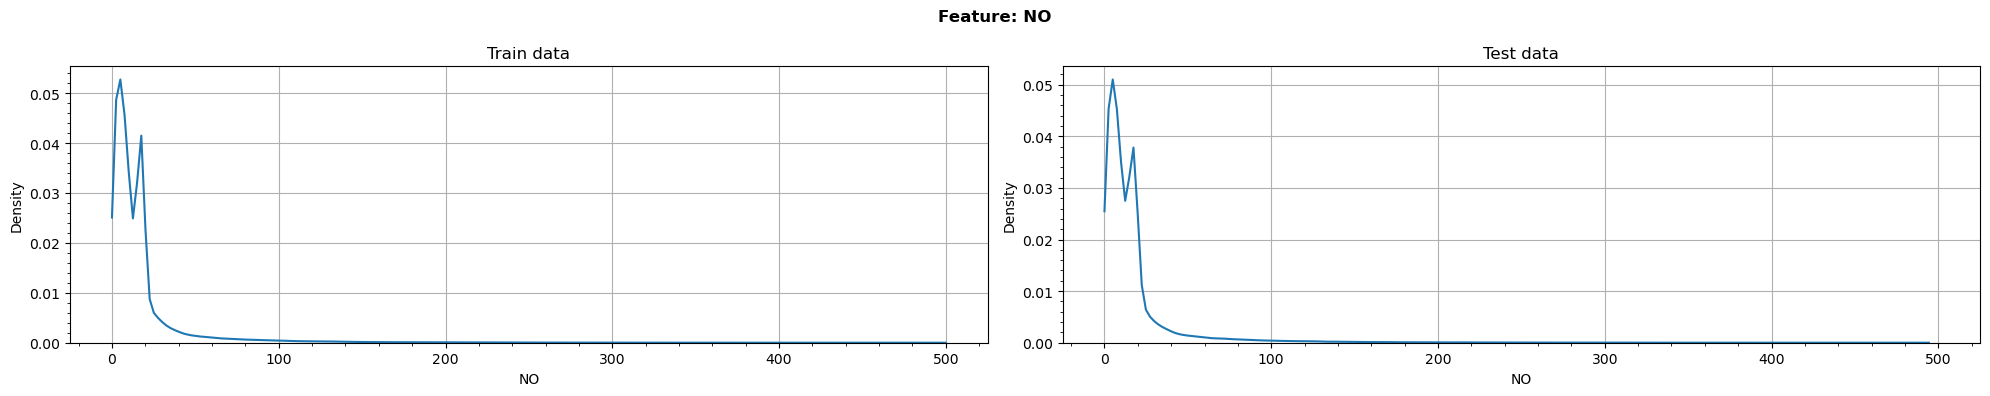


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,67387.0,17.3251,29.0742,0.0,4.6,9.8,17.4,499.5
1,66717.0,17.3327,29.4563,0.0,4.6,9.9,17.4,489.4
2,66828.0,17.3055,29.0793,0.0,4.5,9.8,17.4,490.4
3,67219.0,17.3180,28.8641,0.0,4.6,9.9,17.4,499.0
4,67310.0,17.4496,29.6006,0.0,4.6,9.8,17.4,496.2
5,67484.0,17.6897,30.2183,0.0,4.6,9.9,17.4,500.0
6,67049.0,17.3784,29.1131,0.0,4.6,9.8,17.4,474.6



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,25518.0,3.0021,1.9854,0.0,1.0,3.0,5.0,6.0


In [34]:
explore_cont('NO')

Missing values %: Train - 1.13, Test - 1.19

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,489898.0,28.8933,26.6346,0.0,12.4,25.3,31.9,499.5
Test,209837.0,28.8889,26.6620,0.0,12.4,25.3,31.8,495.6


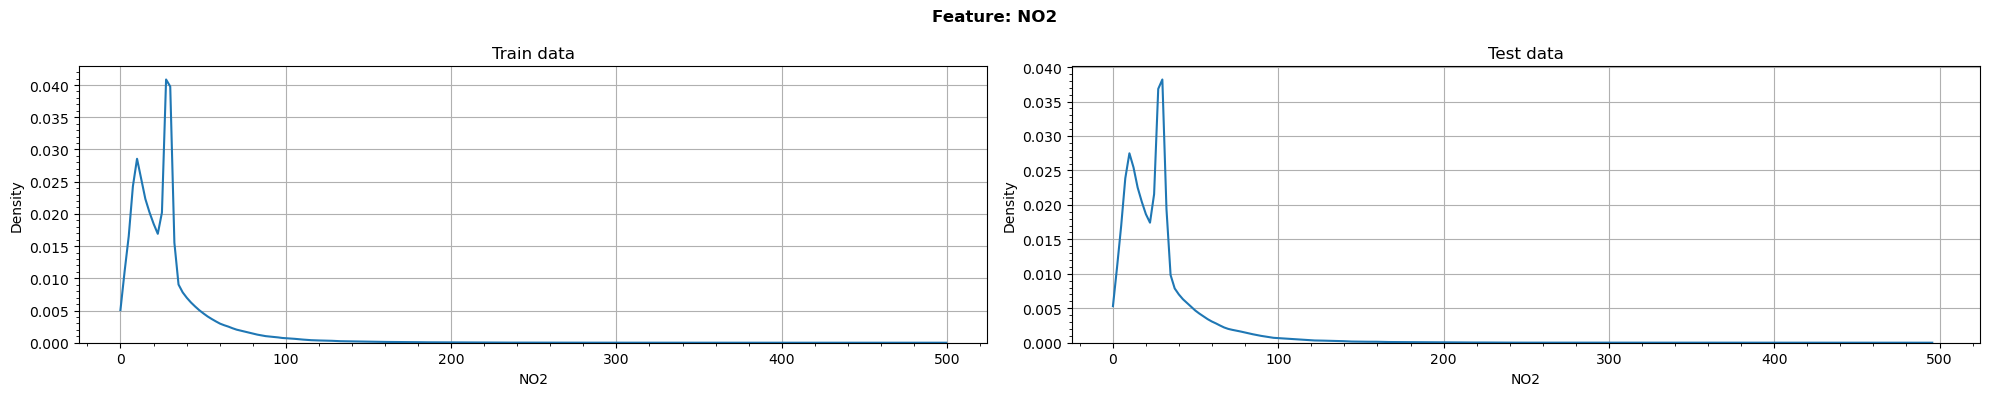


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,70156.0,28.8256,26.5719,0.0,12.4,25.3,31.8,485.2
1,69500.0,28.9613,26.6597,0.0,12.5,25.4,31.9,476.7
2,69664.0,28.8000,26.6408,0.0,12.4,25.3,31.6,468.3
3,70199.0,28.7549,26.1191,0.0,12.4,25.2,31.9,482.2
4,70275.0,28.8396,26.6239,0.0,12.4,25.2,31.8,478.2
5,70303.0,29.0688,26.8541,0.0,12.5,25.5,32.1,478.2
6,69801.0,29.0031,26.9661,0.0,12.4,25.3,31.9,499.5



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,5614.0,2.9829,2.0104,0.0,1.0,3.0,5.0,6.0


In [35]:
explore_cont('NO2')

Missing values %: Train - 2.10, Test - 2.09

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,485090.0,32.2977,36.0973,0.0,12.8,26.1,32.3,498.3
Test,207920.0,32.2832,36.2452,0.0,12.8,26.1,32.3,498.6


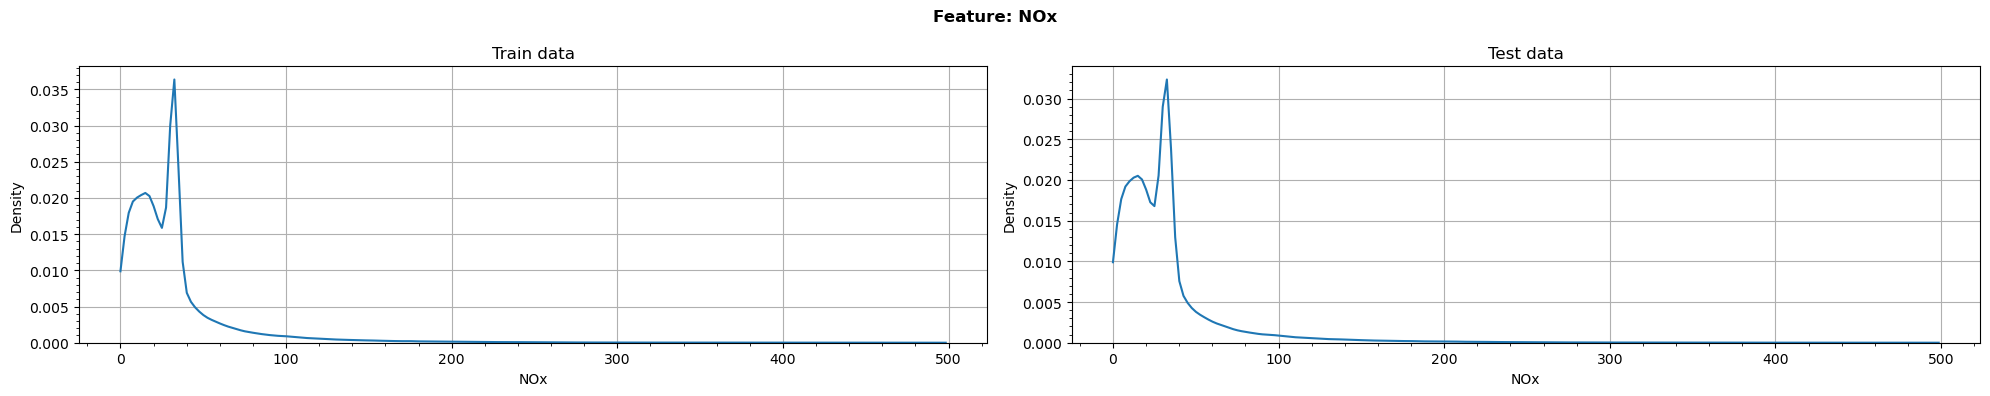


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,69464.0,32.1172,35.5080,0.0,12.8,26.1,32.3,493.1
1,68801.0,32.2295,35.9081,0.0,12.9,26.2,32.5,491.8
2,69040.0,32.2188,35.8204,0.0,12.8,26.2,32.3,493.4
3,69558.0,32.2207,35.8768,0.0,12.9,26.2,32.4,488.4
4,69548.0,32.3551,36.3250,0.0,12.8,26.1,32.3,496.3
5,69603.0,32.5698,36.6806,0.0,12.8,26.1,32.5,498.3
6,69076.0,32.3713,36.5446,0.0,12.8,26.1,32.3,493.7



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,10422.0,3.0104,2.0168,0.0,1.0,3.0,5.0,6.0


In [36]:
explore_cont('NOx')

All NO* values missing:

In [37]:
train.loc[(train['NO'].isna()) & (train['NO2'].isna()) & (train['NOx'].isna())]

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,year,month,day,day_of_week,hour
59948,Ahmedabad,75.3,142.6,NaN,NaN,NaN,23.6,2.6,NaN,19.2,2.8,46.6,1.1,3,5,3,9,0,23
196758,Delhi,267.6,418.6,NaN,NaN,NaN,86.6,0.6,13.2,34.8,7.4,15.9,3.1,3,1,12,2,4,7
449264,Thiruvananthapuram,31.2,47.0,NaN,NaN,NaN,4.7,2.5,59.7,74.6,3.1,8.7,3.1,1,3,12,25,1,14


In [38]:
test.loc[(test['NO'].isna()) & (test['NO2'].isna()) & (test['NOx'].isna())]

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,year,month,day,day_of_week,hour
53394,Chennai,63.3,119.1,NaN,NaN,NaN,23.6,0.0,NaN,11.1,0.0,NaN,3.1,2,3,29,2,0
131606,Mumbai,67.6,119.1,NaN,NaN,NaN,23.6,0.0,14.0,NaN,0.0,0.0,0.0,0,7,11,5,13


High NO* values:

In [39]:
train.loc[(train['NO'] > 100) & (train['NO2'] > 100) & (train['NOx'] > 100)].sample(5)

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,year,month,day,day_of_week,hour
482739,Delhi,228.9,291.3,186.3,122.1,177.4,43.5,2.8,20.5,217.5,7.2,30.6,3.1,2,1,3,2,2,1
261327,Kolkata,189.3,362.5,220.9,125.4,286.8,39.8,3.2,11.4,6.3,85.8,NaN,12.8,3,5,1,15,2,23
468467,Patna,254.0,119.1,164.4,118.7,130.5,23.6,2.5,72.0,19.8,16.0,56.7,72.8,5,4,11,12,1,23
8769,Ahmedabad,99.3,184.4,110.1,173.6,210.2,23.6,110.1,114.2,22.8,1.2,23.4,2.0,5,4,9,25,2,2
211586,Ahmedabad,123.7,179.1,285.8,342.3,461.0,23.6,285.8,14.0,20.1,1.2,23.4,2.0,4,4,10,17,3,23


### NH3

Missing values %: Train - 4.14, Test - 4.16

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,474977.0,23.6053,22.6966,0.0,12.3,23.6,23.6,498.5
Test,203522.0,23.6277,22.4231,0.0,12.3,23.6,23.6,500.0


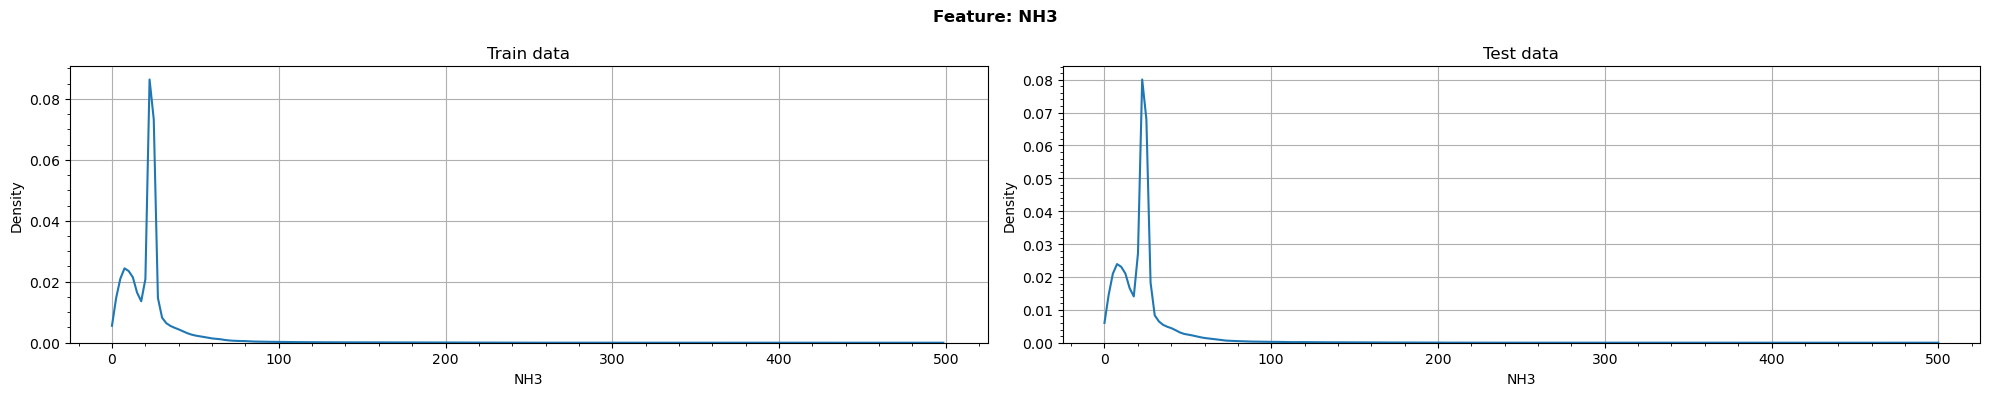


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,68093.0,23.5878,22.6586,0.0,12.2,23.6,23.6,485.8
1,67306.0,23.8475,23.8892,0.0,12.4,23.6,23.6,498.0
2,67578.0,23.5633,23.1088,0.0,12.2,23.6,23.6,485.5
3,68048.0,23.5794,22.5403,0.0,12.3,23.6,23.6,495.2
4,68098.0,23.4831,22.0808,0.0,12.4,23.6,23.6,498.5
5,68158.0,23.6075,22.5949,0.0,12.2,23.6,23.6,484.2
6,67696.0,23.5704,21.9597,0.0,12.3,23.6,23.6,497.4



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,20535.0,3.0011,1.9961,0.0,1.0,3.0,5.0,6.0


In [40]:
explore_cont('NH3')

In [41]:
train.loc[train['NH3'] > 100].sample(5)

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,year,month,day,day_of_week,hour
415421,Chennai,39.8,119.1,8.0,17.3,11.8,152.8,0.6,4.9,65.5,0.4,0.0,3.1,0,2,10,24,1,16
163774,Chandigarh,40.0,107.1,5.0,20.3,14.2,100.4,0.6,9.9,24.4,5.4,0.2,0.6,6,5,2,28,4,16
48623,Chennai,124.7,119.1,4.2,25.0,16.5,199.3,1.4,7.1,36.2,4.8,7.9,3.1,3,1,3,19,5,12
341262,Chennai,35.5,119.1,6.0,8.9,7.4,115.1,0.7,6.0,52.4,0.5,0.0,3.1,5,3,2,19,0,18
402474,Chennai,63.0,119.1,4.4,13.8,14.2,204.6,1.2,4.2,NaN,38.0,3.7,3.1,1,1,1,22,4,20


### CO

Missing values %: Train - 1.01, Test - 0.97

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,490495.0,2.1938,10.4917,0.0,0.5,0.9,2.0,498.6
Test,210302.0,2.1680,9.8083,0.0,0.5,0.9,2.0,485.7


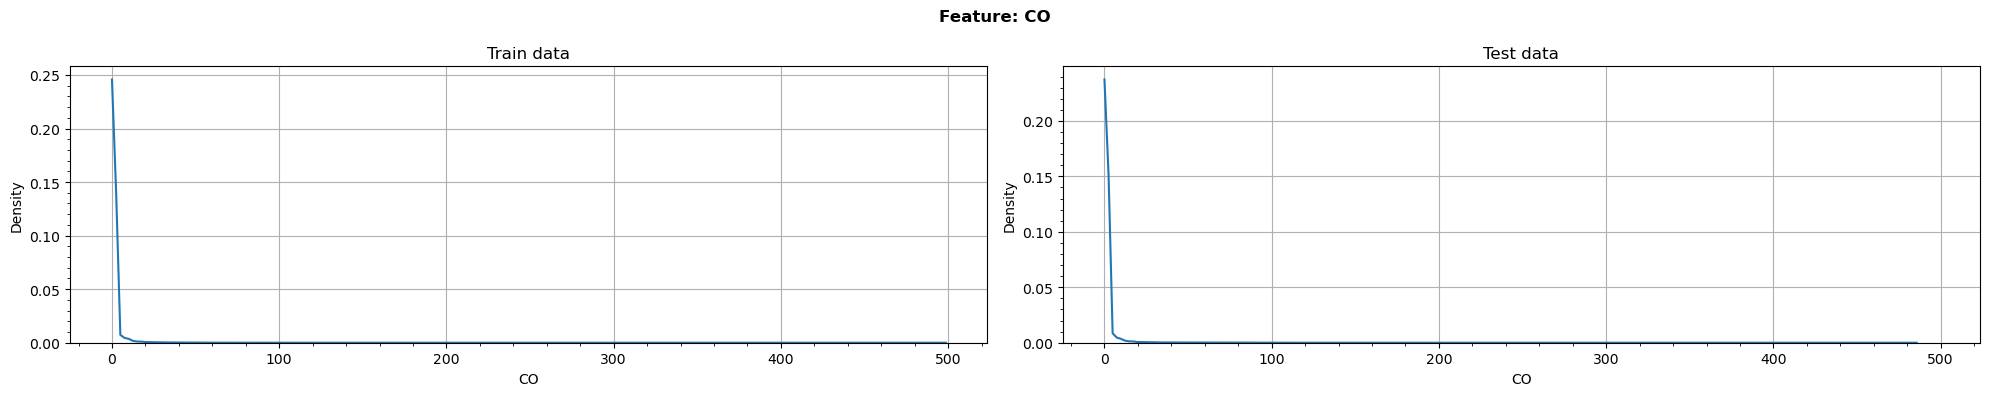


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,70259.0,2.1455,9.8659,0.0,0.5,0.9,2.0,494.9
1,69645.0,2.2153,10.2556,0.0,0.5,0.9,2.0,470.7
2,69746.0,2.1759,10.5143,0.0,0.5,0.9,2.0,452.9
3,70305.0,2.1605,10.2699,0.0,0.5,0.9,1.9,498.6
4,70274.0,2.2481,11.2704,0.0,0.5,0.9,2.0,483.4
5,70375.0,2.2440,11.0413,0.0,0.5,0.9,2.0,490.4
6,69891.0,2.1671,10.1473,0.0,0.5,0.9,2.0,428.7



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,5017.0,3.0343,1.9966,0.0,1.0,3.0,5.0,6.0


In [42]:
explore_cont('CO')

In [43]:
len(train.loc[train['CO'] > 2]), len(train.loc[train['CO'] > 10]), len(train.loc[train['CO'] > 50])

(118797, 13123, 2085)

In [44]:
train.loc[train['CO'] > 50].sample(5)

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,year,month,day,day_of_week,hour
456614,Ahmedabad,25.5,84.1,60.9,171.4,153.0,23.6,60.9,14.0,13.6,6.3,80.0,1.5,2,4,7,13,5,7
218375,Ahmedabad,NaN,119.1,53.4,54.5,110.2,23.6,53.4,79.2,13.0,30.9,106.0,17.7,3,0,3,20,4,1
233376,Ahmedabad,80.1,119.1,64.9,154.0,72.8,23.6,64.9,NaN,2.0,4.0,32.4,7.0,0,4,2,14,3,23
127577,Ahmedabad,136.3,119.1,104.3,167.9,159.7,23.6,104.3,14.0,8.0,9.2,34.0,14.2,1,2,11,23,3,22
249231,Ahmedabad,88.8,119.1,194.6,96.0,131.2,23.6,194.6,99.0,2.5,4.0,32.2,6.8,4,3,11,23,4,21


In [45]:
train.loc[train['CO'] > 50]['City'].value_counts()

Ahmedabad    2085
Name: City, dtype: int64

### SO2

Missing values %: Train - 2.45, Test - 2.44

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,483354.0,14.0270,17.4067,0.0,5.6,10.6,14.0,200.0
Test,207179.0,14.0371,17.5021,0.0,5.6,10.6,14.0,199.9


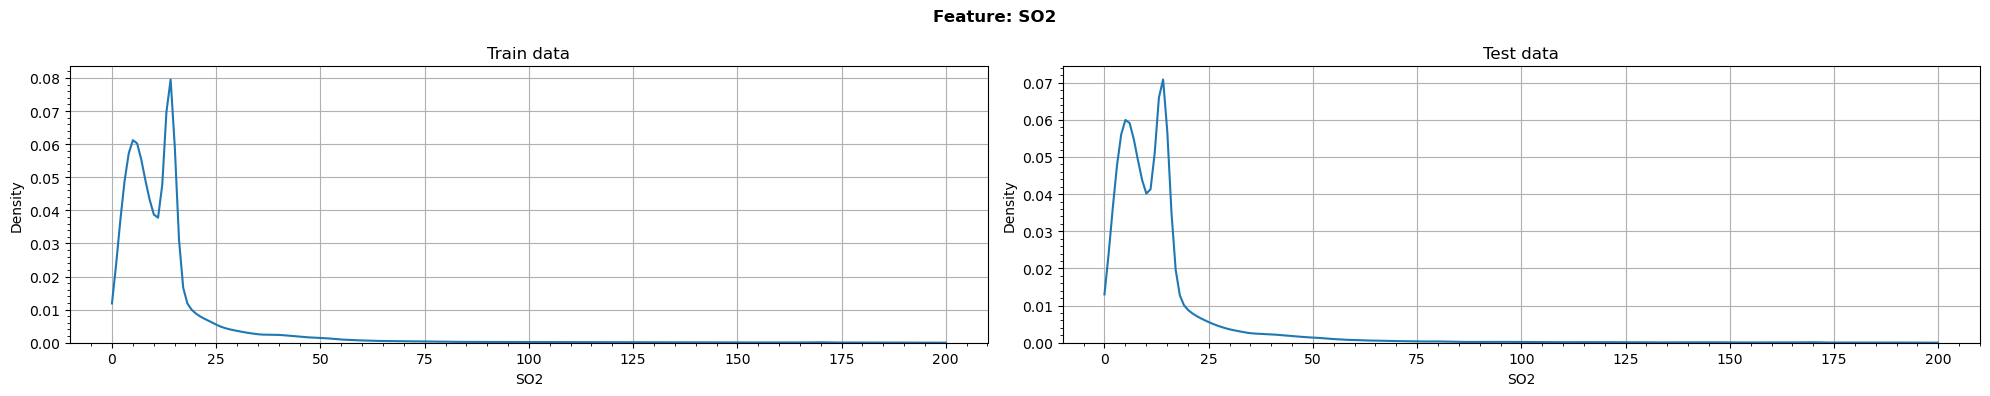


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,69196.0,14.0620,17.5433,0.0,5.600,10.6,14.0,199.3
1,68581.0,14.0595,17.5874,0.0,5.600,10.6,14.0,199.7
2,68704.0,13.9472,17.1916,0.0,5.600,10.6,14.0,200.0
3,69350.0,14.0041,17.3806,0.0,5.525,10.6,14.0,199.8
4,69347.0,13.9879,17.3483,0.0,5.600,10.6,14.0,200.0
5,69323.0,14.0992,17.5013,0.0,5.600,10.7,14.0,199.5
6,68853.0,14.0286,17.2903,0.0,5.600,10.7,14.0,199.2



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,12158.0,2.9965,2.0147,0.0,1.0,3.0,5.0,6.0


In [46]:
explore_cont('SO2')

In [47]:
len(train.loc[train['SO2'] > 25]), len(train.loc[train['SO2'] > 50]), len(train.loc[train['SO2'] > 100])

(48674, 16261, 4716)

In [48]:
train.loc[train['SO2'] > 100].sample(5)

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_Bucket,year,month,day,day_of_week,hour
492840,Ahmedabad,79.7,123.6,17.1,69.0,46.4,23.6,17.1,114.1,25.0,1.2,38.6,0.5,6,5,2,4,1,3
30340,Ahmedabad,44.6,141.4,8.7,145.3,80.8,23.6,8.7,131.1,34.8,6.3,80.0,1.5,6,4,6,12,2,12
237032,Ahmedabad,45.2,119.1,5.1,48.2,27.4,23.6,5.1,119.4,49.1,0.7,29.5,3.2,0,3,3,9,4,5
23489,Jorapokhar,82.2,154.6,8.0,9.9,32.3,6.2,2.2,121.4,18.0,3.1,8.7,3.1,1,4,2,5,1,19
294871,Ahmedabad,15.8,119.1,108.8,287.1,221.2,23.6,108.8,107.0,15.6,3.9,16.0,0.6,6,3,9,30,6,0


In [49]:
train.loc[train['SO2'] > 100]['City'].value_counts()

Ahmedabad             3241
Jorapokhar             750
Patna                  171
Hyderabad              170
Lucknow                103
Amaravati               69
Talcher                 52
Visakhapatnam           36
Amritsar                32
Gurugram                30
Bengaluru               24
Delhi                   19
Chennai                 11
Thiruvananthapuram       2
Jaipur                   2
Bhopal                   1
Guwahati                 1
Kolkata                  1
Chandigarh               1
Name: City, dtype: int64

### O3

Missing values %: Train - 4.77, Test - 4.71

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,471898.0,34.8268,26.9473,0.0,16.2,34.0,41.6,497.6
Test,202353.0,34.7386,26.9481,0.0,16.1,33.8,41.4,474.6


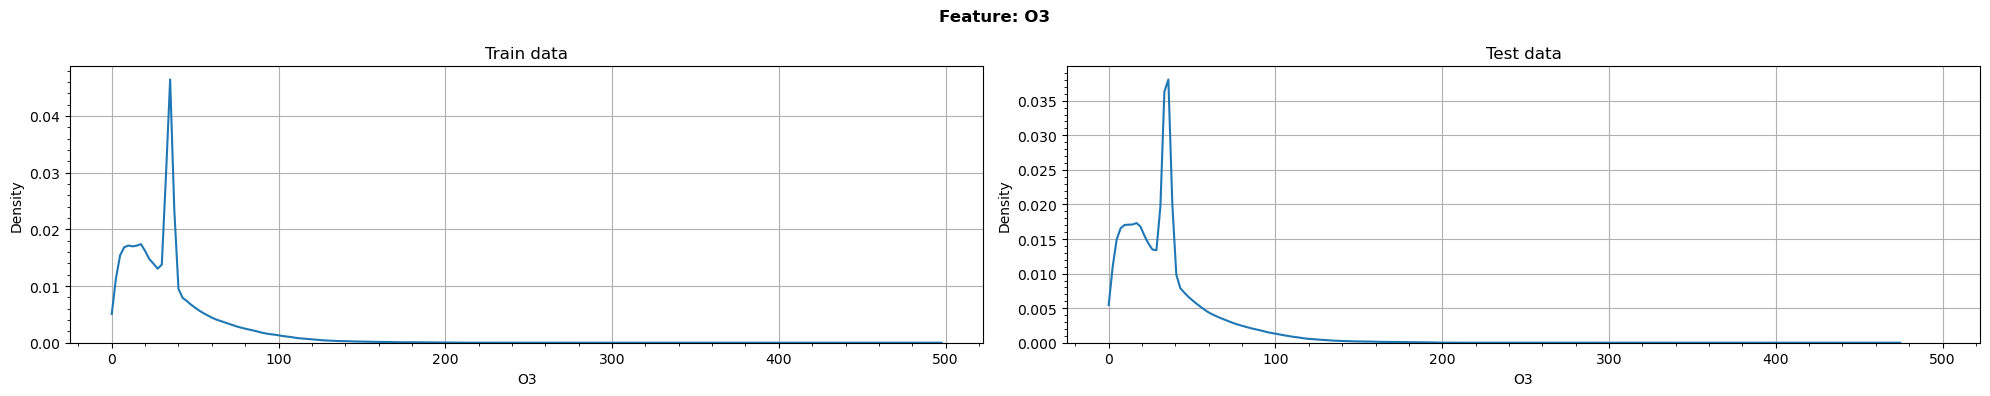


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,67557.0,34.8897,26.9977,0.0,16.3,34.0,41.5,334.0
1,66981.0,34.8797,27.0142,0.0,16.2,34.1,41.6,321.0
2,67147.0,34.8909,26.9240,0.0,16.2,34.1,41.8,471.1
3,67669.0,34.7783,26.9546,0.0,16.2,33.8,41.6,497.6
4,67588.0,34.7917,26.9914,0.0,16.2,33.8,41.4,474.2
5,67715.0,34.8013,26.8762,0.0,16.2,34.0,41.6,332.9
6,67241.0,34.7564,26.8734,0.0,16.0,34.0,41.5,323.2



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,23614.0,3.004,2.0032,0.0,1.0,3.0,5.0,6.0


In [50]:
explore_cont('O3')

In [51]:
len(train.loc[train['O3'] > 100]), len(train.loc[train['O3'] > 200])

(15662, 126)

In [52]:
train.loc[train['O3'] > 200]['City'].value_counts()

Delhi    126
Name: City, dtype: int64

### BTX

Missing values %: Train - 1.72, Test - 1.69

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,486993.0,3.0922,14.4336,0.0,0.2,1.8,3.1,498.1
Test,208778.0,3.0727,14.3448,0.0,0.2,1.8,3.1,498.1


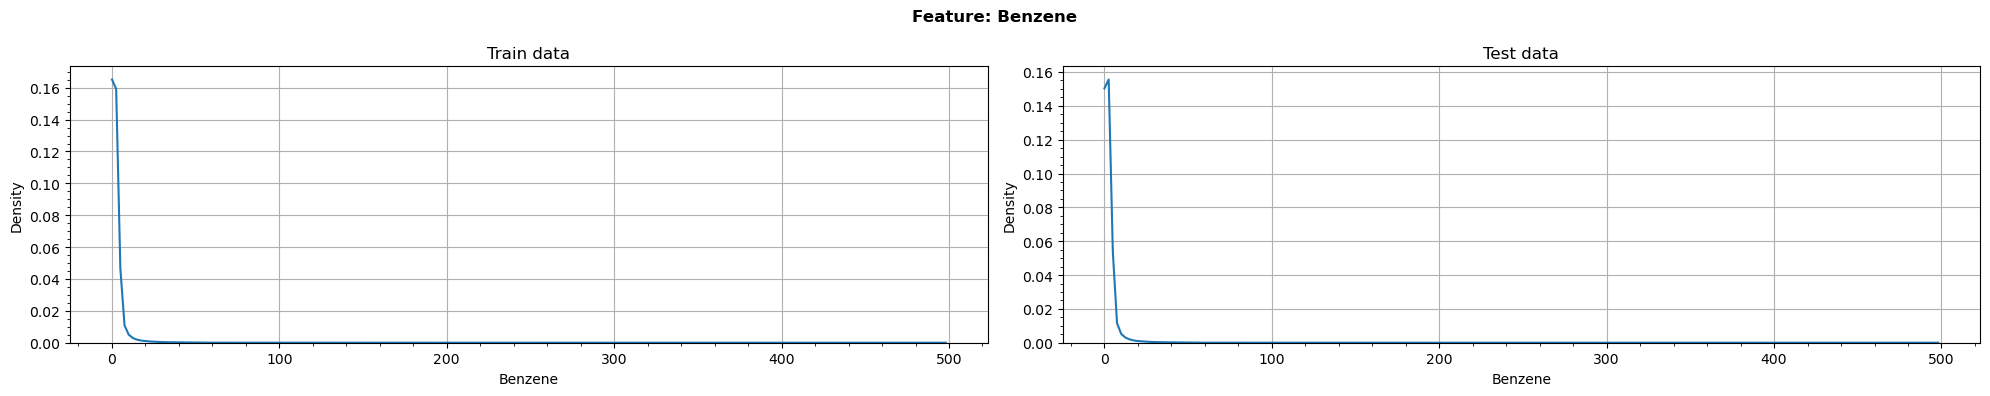


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,69772.0,3.0469,13.8032,0.0,0.2,1.8,3.1,484.7
1,69161.0,2.9673,12.1942,0.0,0.2,1.8,3.1,491.5
2,69192.0,3.1902,15.4371,0.0,0.2,1.9,3.1,491.5
3,69832.0,3.0957,15.0339,0.0,0.2,1.8,3.1,491.5
4,69792.0,3.1126,14.5562,0.0,0.2,1.8,3.1,491.5
5,69908.0,3.1468,15.0094,0.0,0.2,1.8,3.1,488.5
6,69336.0,3.0855,14.7412,0.0,0.2,1.8,3.1,498.1



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,8519.0,3.0317,2.0041,0.0,1.0,3.0,5.0,6.0


In [53]:
explore_cont('Benzene')

In [54]:
len(train.loc[train['Benzene'] > 5]), len(train.loc[train['Benzene'] > 20]), len(train.loc[train['Benzene'] > 100])

(45756, 6745, 724)

Missing values %: Train - 2.22, Test - 2.18

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,484508.0,8.6561,17.9554,0.0,1.2,7.4,8.7,499.4
Test,207723.0,8.6974,18.1265,0.0,1.2,7.5,8.7,498.1


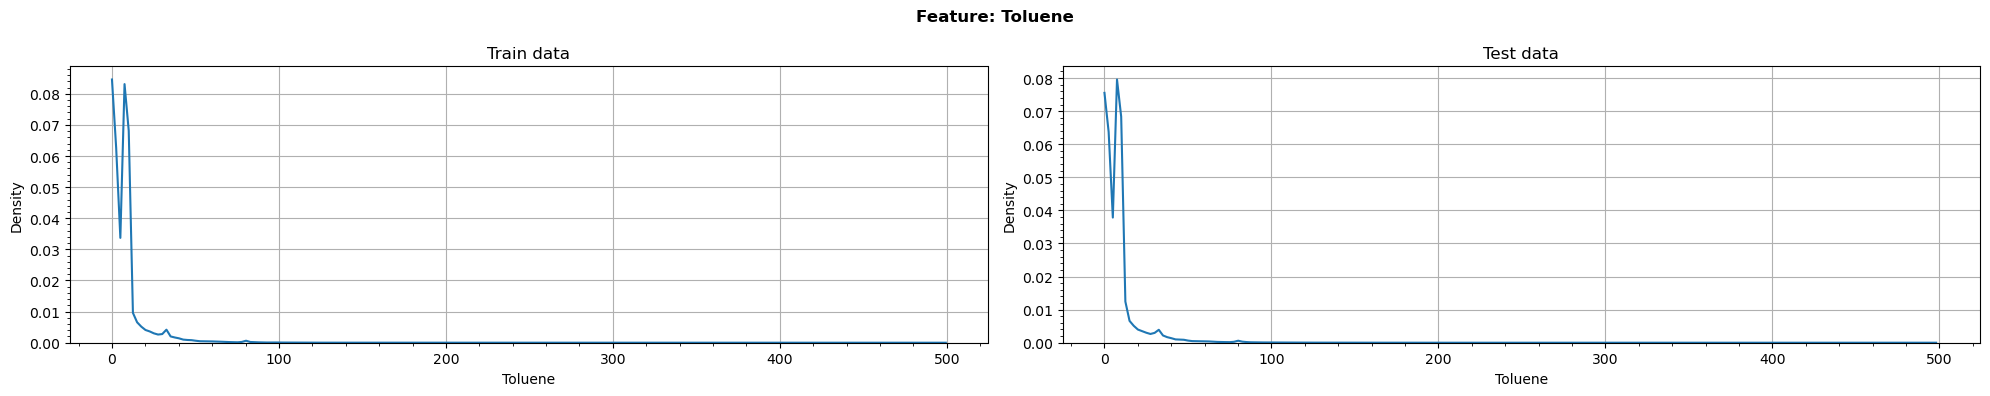


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,69417.0,8.6132,17.2420,0.0,1.1,7.4,8.7,499.4
1,68784.0,8.5363,16.5145,0.0,1.2,7.4,8.7,491.6
2,68824.0,8.7015,18.6655,0.0,1.2,7.6,8.7,485.7
3,69432.0,8.6343,18.4920,0.0,1.2,7.4,8.7,491.5
4,69407.0,8.6495,18.3825,0.0,1.1,7.2,8.7,491.5
5,69538.0,8.7526,18.1384,0.0,1.1,7.4,8.7,488.5
6,69106.0,8.7044,18.1456,0.0,1.2,7.6,8.7,498.1



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,11004.0,2.9907,1.982,0.0,1.0,3.0,5.0,6.0


In [55]:
explore_cont('Toluene')

In [56]:
len(train.loc[train['Toluene'] > 5]), len(train.loc[train['Toluene'] > 20]), len(train.loc[train['Toluene'] > 100])

(271754, 40078, 1535)

Missing values %: Train - 2.45, Test - 2.44

Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,483352.0,3.1147,4.7406,0.0,2.3,3.1,3.1,500.0
Test,207181.0,3.1006,4.5253,0.0,2.4,3.1,3.1,461.4


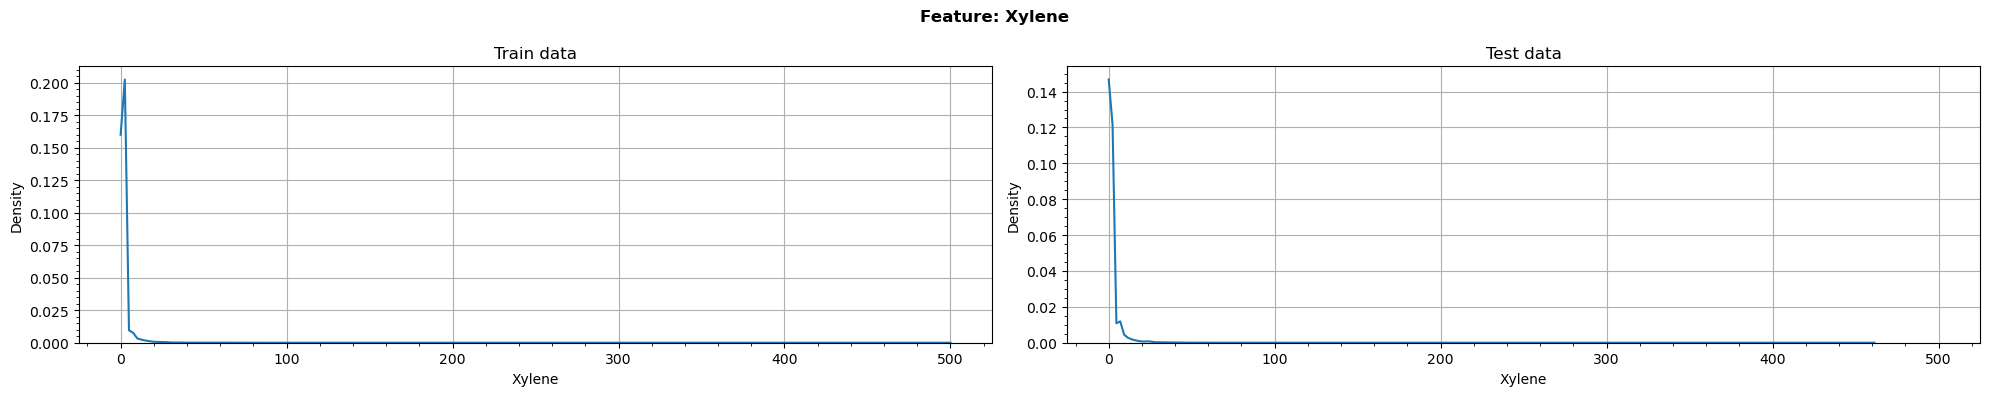


Feature distribution grouped by target:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,,,,,,,,
0,69238.0,3.1258,4.8580,0.0,2.2,3.1,3.1,278.7
1,68638.0,3.1110,4.8380,0.0,2.2,3.1,3.1,402.6
2,68663.0,3.1179,4.6509,0.0,2.3,3.1,3.1,320.0
3,69346.0,3.0903,4.7943,0.0,2.2,3.1,3.1,500.0
4,69253.0,3.1019,4.4871,0.0,2.2,3.1,3.1,229.8
5,69361.0,3.1280,4.7019,0.0,2.4,3.1,3.1,327.2
6,68853.0,3.1281,4.8430,0.0,2.4,3.1,3.1,433.9



Target distribution for missing values:


,count,mean,std,min,25%,50%,75%,max
AQI_Bucket,12160.0,3.0144,2.0017,0.0,1.0,3.0,5.0,6.0


In [57]:
explore_cont('Xylene')

In [58]:
len(train.loc[train['Xylene'] > 5]), len(train.loc[train['Xylene'] > 20]), len(train.loc[train['Xylene'] > 50])

(30154, 4284, 599)

# Feature correlation

In [59]:
def plot_corr_matrix(corr_df, size=10):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        corr_df, mask=np.triu(np.ones_like(corr_df)),
        vmin=-1, vmax=1, center=0,
        annot=True, linewidths=0.1,
        fmt='.2f', annot_kws={'fontsize': 8})
    plt.show()

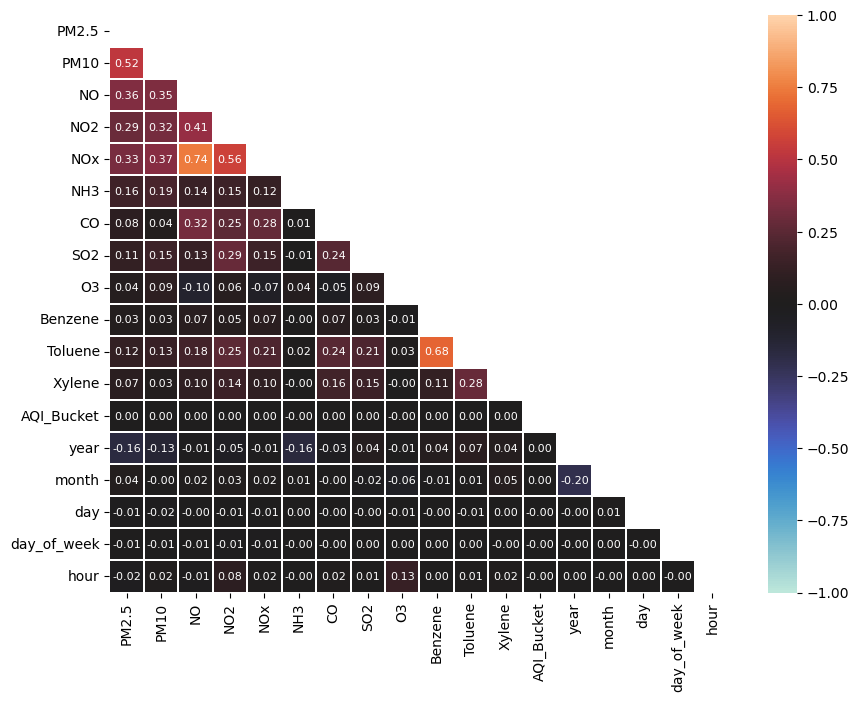

In [60]:
pearson_df = train.corr(method='pearson')
plot_corr_matrix(pearson_df)

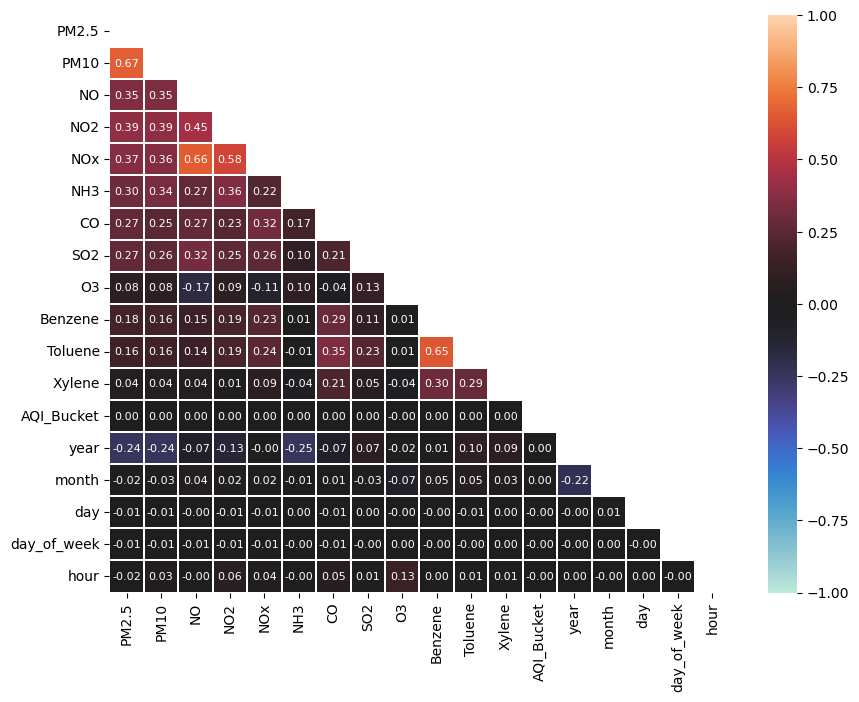

In [61]:
spearman_df = train.corr(method='spearman')
plot_corr_matrix(spearman_df)

# Adversarial validation

In [62]:
train = train.fillna(-999)
test = test.fillna(-999)

train_ohe = pd.get_dummies(train)
test_ohe = pd.get_dummies(test)

gc.collect()

32813

In [63]:
def adversarial_validation(first_dataset, second_dataset, model):
    scores = []
    oof_preds = {}
        
    first_dataset['set'] = 0
    second_dataset['set'] = 1
    composite = pd.concat([first_dataset, second_dataset], axis=0, ignore_index=True)
    
    X, y = composite[features], composite['set']
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds.update(dict(zip(val_idx, val_preds)))
        auc = roc_auc_score(y_val, val_preds)
        scores.append(auc)
        print(f'Fold #{fold}: AUC = {auc:.5f}')
        _ = gc.collect()
        
    oof_preds = pd.Series(oof_preds).sort_index()
    print(f'OOF AUC = {roc_auc_score(y, oof_preds):.5f}\n')

In [64]:
model = ExtraTreesClassifier(
    n_estimators=150, 
    max_depth=7, 
    n_jobs=-1, 
    random_state=SEED)

features = list(test_ohe.columns)

In [65]:
%%time
adversarial_validation(train_ohe[features].copy(), test_ohe[features].copy(), model)

Fold #0: AUC = 0.50056
Fold #1: AUC = 0.49664
Fold #2: AUC = 0.49969
Fold #3: AUC = 0.49828
Fold #4: AUC = 0.50033
OOF AUC = 0.49886

CPU times: user 10min 2s, sys: 1.24 s, total: 10min 4s
Wall time: 2min 39s


# Baseline

In [66]:
def eval_metric(y_true, y_pred): # RMSLE
    return mean_squared_log_error(y_true, y_pred, squared=False)

In [67]:
def cross_val_predict(model, data, task=None, num_folds=5):
    scores = []
    test_preds = {}
    oof_preds = {}
    
    X, y, X_test = data
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]       
        
        model.fit(X_train, y_train)
        
        if task == 'CLF':
            val_preds = model.predict(X_val)
            test_preds[f'fold{fold}'] = model.predict(X_test)
        elif task == 'REG':
            val_preds = np.clip(model.predict(X_val), 0, 6)
            test_preds[f'fold{fold}'] = np.clip(model.predict(X_test), 0, 6)
        else:
            print('\nInvalid task\n')
            return
            
        oof_preds.update(dict(zip(val_idx, val_preds)))
    
        score = eval_metric(y_val, val_preds)
        scores.append(score)
        print(f'Fold #{fold}: {score:.5f}')
        _ = gc.collect()
    
    test_preds = pd.DataFrame.from_dict(test_preds)
    if task == 'CLF': # aggregate = mode
        test_preds['agg'] = test_preds.mode(axis=1)[0].astype('int')
    elif task == 'REG': # aggregate = mean
        test_preds['agg'] = test_preds.mean(axis=1)
        
    oof_preds = pd.Series(oof_preds).sort_index()
    print(f'OOF score: {eval_metric(y, oof_preds):.5f}\n')
    
    return oof_preds, test_preds

## Classification

In [68]:
clf = ExtraTreesClassifier(
    n_estimators=250, 
    max_depth=7, 
    n_jobs=-1, 
    random_state=SEED)

In [69]:
%%time
# All features, 5-folds

oof_clf_all_5f, tp_clf_all_5f = cross_val_predict(
    model=clf,
    data=(train_ohe.drop(TARGET, axis=1), train_ohe[TARGET], test_ohe),
    task='CLF',
    num_folds=5)

Fold #0: 0.89810
Fold #1: 0.99886
Fold #2: 0.93051
Fold #3: 1.01803
Fold #4: 0.93110
OOF score: 0.95640

CPU times: user 13min 27s, sys: 2.21 s, total: 13min 29s
Wall time: 4min 34s


In [70]:
%%time

# All features, 7-folds
oof_clf_all_7f, tp_clf_all_7f = cross_val_predict(
    model=clf,
    data=(train_ohe.drop(TARGET, axis=1), train_ohe[TARGET], test_ohe),
    task='CLF',
    num_folds=7)

Fold #0: 0.94925
Fold #1: 0.87189
Fold #2: 0.96766
Fold #3: 0.93014
Fold #4: 0.98295
Fold #5: 0.96604
Fold #6: 0.92946
OOF score: 0.94310

CPU times: user 19min 30s, sys: 2.61 s, total: 19min 32s
Wall time: 6min 10s


In [71]:
%%time

# All features, 10-folds
oof_clf_all_10f, tp_clf_all_10f = cross_val_predict(
    model=clf,
    data=(train_ohe.drop(TARGET, axis=1), train_ohe[TARGET], test_ohe),
    task='CLF',
    num_folds=10)

Fold #0: 0.94051
Fold #1: 0.92742
Fold #2: 0.91538
Fold #3: 0.97238
Fold #4: 0.91463
Fold #5: 0.92481
Fold #6: 0.96128
Fold #7: 0.94588
Fold #8: 0.97330
Fold #9: 0.88466
OOF score: 0.93641

CPU times: user 28min 36s, sys: 3.31 s, total: 28min 40s
Wall time: 8min 32s


In [72]:
%%time

# 'City' dropped, 5-folds
oof_clf_red_5f, tp_clf_red_5f = cross_val_predict(
    model=clf,
    data=(train.drop(['City', TARGET], axis=1), train[TARGET], test.drop('City', axis=1)),
    task='CLF', 
    num_folds=5)

Fold #0: 0.84881
Fold #1: 1.06722
Fold #2: 0.87629
Fold #3: 0.90633
Fold #4: 0.86021
OOF score: 0.91528

CPU times: user 11min 46s, sys: 1.69 s, total: 11min 48s
Wall time: 4min 8s


In [73]:
%%time

# 'City' dropped, 7-folds
oof_clf_red_7f, tp_clf_red_7f = cross_val_predict(
    model=clf,
    data=(train.drop(['City', TARGET], axis=1), train[TARGET], test.drop('City', axis=1)),
    task='CLF', 
    num_folds=7)

Fold #0: 0.94588
Fold #1: 0.87619
Fold #2: 1.04112
Fold #3: 0.92357
Fold #4: 1.01694
Fold #5: 0.88725
Fold #6: 0.95016
OOF score: 0.95045

CPU times: user 17min, sys: 2.17 s, total: 17min 2s
Wall time: 5min 30s


In [74]:
%%time

# 'City' dropped, 10-folds
oof_clf_red_10f, tp_clf_red_10f = cross_val_predict(
    model=clf,
    data=(train.drop(['City', TARGET], axis=1), train[TARGET], test.drop('City', axis=1)),
    task='CLF', 
    num_folds=10)

Fold #0: 0.84793
Fold #1: 0.92798
Fold #2: 0.93991
Fold #3: 1.02817
Fold #4: 0.88744
Fold #5: 0.87370
Fold #6: 1.00746
Fold #7: 0.89801
Fold #8: 0.90196
Fold #9: 0.93716
OOF score: 0.92654

CPU times: user 24min 55s, sys: 2.74 s, total: 24min 58s
Wall time: 7min 34s


## Regression

In [75]:
reg = ExtraTreesRegressor(
    n_estimators=250, 
    max_depth=7, 
    n_jobs=-1, 
    random_state=SEED)

In [76]:
%%time

# All features, 5-folds
oof_reg_all_5f, tp_reg_all_5f = cross_val_predict(
    model=reg,
    data=(train_ohe.drop(TARGET, axis=1), train_ohe[TARGET], test_ohe),
    task='REG',
    num_folds=5)

Fold #0: 0.65636
Fold #1: 0.65633
Fold #2: 0.65635
Fold #3: 0.65638
Fold #4: 0.65634
OOF score: 0.65635

CPU times: user 38min 29s, sys: 1.7 s, total: 38min 30s
Wall time: 9min 54s


In [77]:
%%time

# All features, 7-folds
oof_reg_all_7f, tp_reg_all_7f = cross_val_predict(
    model=reg,
    data=(train_ohe.drop(TARGET, axis=1), train_ohe[TARGET], test_ohe),
    task='REG',
    num_folds=7)

Fold #0: 0.65635
Fold #1: 0.65632
Fold #2: 0.65633
Fold #3: 0.65637
Fold #4: 0.65637
Fold #5: 0.65635
Fold #6: 0.65633
OOF score: 0.65635

CPU times: user 57min 44s, sys: 2.58 s, total: 57min 46s
Wall time: 14min 51s


In [78]:
%%time

# All features, 10-folds
oof_reg_all_10f, tp_reg_all_10f = cross_val_predict(
    model=reg,
    data=(train_ohe.drop(TARGET, axis=1), train_ohe[TARGET], test_ohe),
    task='REG',
    num_folds=10)

Fold #0: 0.65640
Fold #1: 0.65631
Fold #2: 0.65634
Fold #3: 0.65634
Fold #4: 0.65638
Fold #5: 0.65632
Fold #6: 0.65634
Fold #7: 0.65635
Fold #8: 0.65633
Fold #9: 0.65633
OOF score: 0.65634

CPU times: user 1h 26min 39s, sys: 3.87 s, total: 1h 26min 43s
Wall time: 22min 17s


In [79]:
%%time

# 'City' dropped, 5-folds
oof_reg_red_5f, tp_reg_red_5f = cross_val_predict(
    model=reg,
    data=(train.drop(['City', TARGET], axis=1), train[TARGET], test.drop('City', axis=1)),
    task='REG', 
    num_folds=5)

Fold #0: 0.65633
Fold #1: 0.65633
Fold #2: 0.65633
Fold #3: 0.65633
Fold #4: 0.65634
OOF score: 0.65633

CPU times: user 16min 30s, sys: 943 ms, total: 16min 31s
Wall time: 4min 19s


In [80]:
%%time

# 'City' dropped, 7-folds
oof_reg_red_7f, tp_reg_red_7f = cross_val_predict(
    model=reg,
    data=(train.drop(['City', TARGET], axis=1), train[TARGET], test.drop('City', axis=1)),
    task='REG', 
    num_folds=7)

Fold #0: 0.65632
Fold #1: 0.65632
Fold #2: 0.65631
Fold #3: 0.65635
Fold #4: 0.65631
Fold #5: 0.65633
Fold #6: 0.65633
OOF score: 0.65632

CPU times: user 26min, sys: 1.57 s, total: 26min 1s
Wall time: 6min 48s


In [81]:
%%time

# 'City' dropped, 10-folds
oof_reg_red_10f, tp_reg_red_10f = cross_val_predict(
    model=reg,
    data=(train.drop(['City', TARGET], axis=1), train[TARGET], test.drop('City', axis=1)),
    task='REG', 
    num_folds=10)

Fold #0: 0.65634
Fold #1: 0.65631
Fold #2: 0.65634
Fold #3: 0.65630
Fold #4: 0.65637
Fold #5: 0.65630
Fold #6: 0.65630
Fold #7: 0.65631
Fold #8: 0.65632
Fold #9: 0.65632
OOF score: 0.65632

CPU times: user 40min 28s, sys: 2.19 s, total: 40min 30s
Wall time: 10min 26s


# Submission files

In [83]:
def create_submission_files(test_preds, config):
    sub = pd.DataFrame(data={'AQI_Bucket': np.round(test_preds['agg'], 2)})
    sub.to_csv(f'{config}.csv', index=False)

In [84]:
create_submission_files(tp_clf_all_5f, 'clf_all_5f')
create_submission_files(tp_clf_all_7f, 'clf_all_7f')
create_submission_files(tp_clf_all_10f, 'clf_all_10f')

create_submission_files(tp_clf_red_5f, 'clf_red_5f')
create_submission_files(tp_clf_red_7f, 'clf_red_7f')
create_submission_files(tp_clf_red_10f, 'clf_red_10f')

In [85]:
create_submission_files(tp_reg_all_5f, 'reg_all_5f')
create_submission_files(tp_reg_all_7f, 'reg_all_7f')
create_submission_files(tp_reg_all_10f, 'reg_all_10f')

create_submission_files(tp_reg_red_5f, 'reg_red_5f')
create_submission_files(tp_reg_red_7f, 'reg_red_7f')
create_submission_files(tp_reg_red_10f, 'reg_red_10f')